In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

In [3]:
import healpy as hp

In [4]:
from astropy.io import fits

In [5]:
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import ICRS

In [6]:
from astropy.wcs import WCS

In [7]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 12
rcParams['legend.borderaxespad'] = 2

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [8]:
freqs = [4.575, 5.625, 6.125, 7.175]
banks = ['A', 'B', 'C', 'D']

In [9]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p.T, hits.T, ra_bins, dec_bins

In [10]:
def calculate_sflux_gal(bank='A', session='5', doplot=True, pixbeam=1., smth=0, removeplane=True):
    dataf = np.load('/home/mabitbol/GBT-S140/datamaps/tod'+bank+'_'+session+'.npz')
    tmask = dataf['tmask']
    ras = dataf['ras'][tmask]
    decs = dataf['decs'][tmask]
    calibrated = dataf['calibrated'][tmask]
    
    tmask2 = ~np.isnan(calibrated)
    ras = ras[tmask2]
    decs = decs[tmask2]
    calibrated = calibrated[tmask2] 
    
    rc = 335.7133441444117
    dc = 63.43802542905474
    
    #c = coordinates.SkyCoord(frame='icrs', ra=ras*u.degree, dec=decs*u.degree)
    #decs = c.galactic.b.deg
    #ras = c.galactic.l.deg
    #rc = 107.2
    #dc = 5.2
    
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    
    # units
    # beam and pixbeam are in arcminutes
    beamarea = np.pi / (4. * np.log(2)) * beam**2
    pixelarea = pixbeam**2
    units = pixelarea / beamarea
    
    # ras and decs are in degrees 
    nrapix = int((ras.max() - ras.min()) / (pixbeam / 60.))
    ndecpix = int((decs.max() - decs.min()) / (pixbeam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated, ras, decs, nrapix, ndecpix) 
    mask = hits == 0
    signal = np.zeros_like(datamap)
    signal[~mask] = datamap[~mask] / hits[~mask] * units
    
    radius = np.sqrt( (ras-rc)**2 + (decs-dc)**2)
    
    rmask = radius <= 1.
    insidedata = np.zeros_like(calibrated)
    insidedata[rmask] = 10.
    innermap, innerhits, rabins, decbins = naive_map(insidedata, ras, decs, nrapix, ndecpix) 
    innerregion = innermap > 0
    
    annulus = (radius >= 80./60.) & (radius <= 2.)
    outerdata = np.zeros_like(calibrated)
    outerdata[annulus] = 10.
    outermap, outerhits, rabins, decbins = naive_map(outerdata, ras, decs, nrapix, ndecpix)
    outerregion = outermap > 0
    
    if removeplane:
        rabinsc = (rabins[1:] + rabins[:-1]) / 2.
        decbinsc = (decbins[1:] + decbins[:-1]) / 2.
        X, Y = np.meshgrid(rabinsc, decbinsc)
        XX = X.flatten()
        YY = Y.flatten()
        Z = signal.flatten()
        masks = ~np.isnan(Z) * ~innerregion.flatten()
        data = np.c_[XX[masks], YY[masks], Z[masks]]
        data2 = np.c_[XX, YY, Z]
        A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        res = C[0] * X + C[1] * Y + C[2]
        signal -= res
        
    signal -= np.nanmedian(signal[outerregion])
    if smth is None:
        smth = beam
    if smth > 0:
        signal = gaussian_filter(signal, smth/pixbeam)
        shits = gaussian_filter(hits, smth/pixbeam)
        mask = shits < 1
    signal[mask] = np.nan
    
    if doplot:
        figure()
        pc = pcolormesh(rabinsc, decbinsc, signal * 1000.)
        clim(-15, 15)
        cb = colorbar()
        #xlabel('$\mathrm{Lon}\ (deg)$')
        #ylabel('$\mathrm{Lat}\ (deg)$')
        cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
        #savefig('s4map_bank'+bank+'session'+session)
    
    print np.nansum(signal[innerregion])
    return rabinsc, decbinsc, signal

38.7369659833


/usr/lib64/python2.7/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


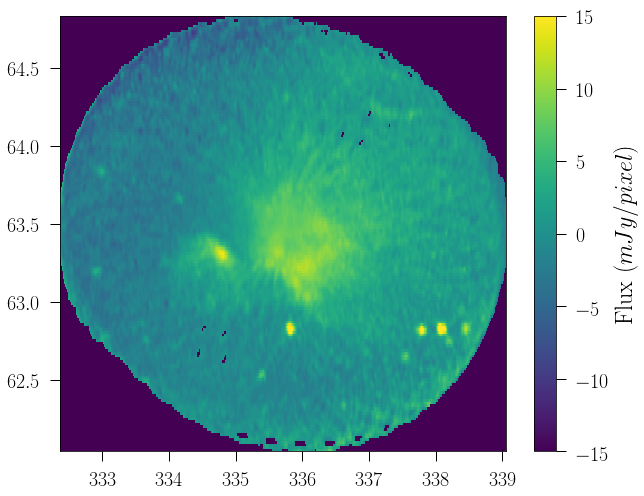

In [11]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=1.)

In [12]:
rabinsc, decbinsc, signal = calculate_sflux_gal('A', '5', smth=None, doplot=False)

38.6034736448


In [13]:
gridx, gridy = np.meshgrid(rabinsc, decbinsc)

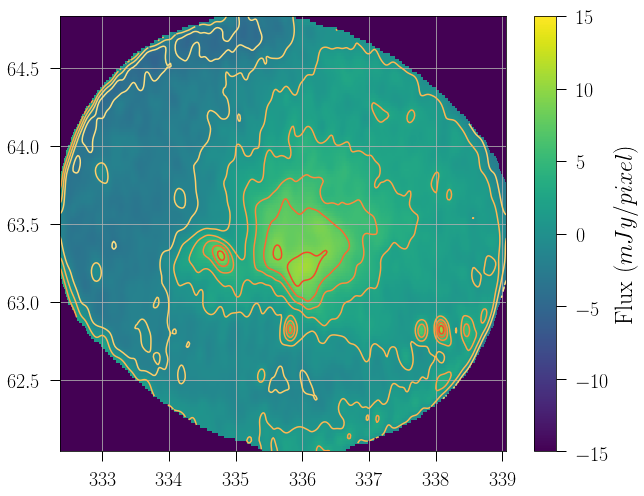

In [14]:
pcolormesh(rabinsc, decbinsc, signal*1000)
clim(-15, 15)
cb = colorbar()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
#xlabel('$\mathrm{Lon}\ (deg)$')
#ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_mapoverlay_A5')

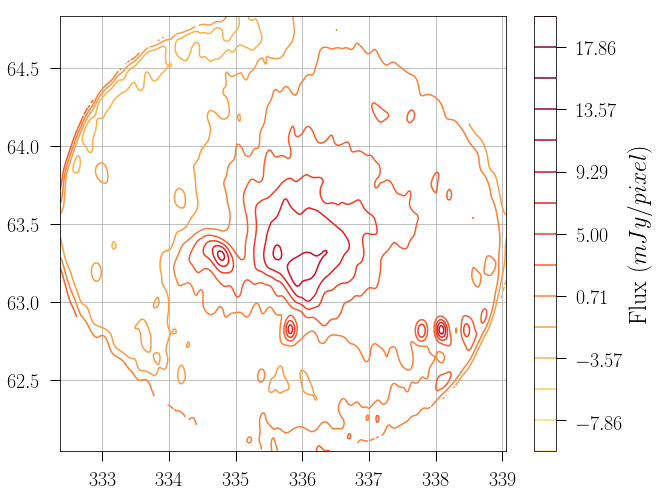

In [15]:
figure()
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
clim(-15, 15)
cb = colorbar()
#xlabel('$\mathrm{Lon}\ (deg)$')
#ylabel('$\mathrm{Lat}\ (deg)$')
cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()
#savefig('s4contour_A5')

In [16]:
hdu = fits.open('../externaldata/new-image.fits')[0]
wcs = WCS(hdu.header)

In [17]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 335.818800184  63.419629949799997  
CRPIX : 1014.30889966  615.61087106800005  
CD1_1 CD1_2  : 0.00116550557175  1.82291764732e-05  
CD2_1 CD2_2  : -1.83843474514e-05  0.0011657516359499999  
NAXIS : 1663  1252

In [ ]:
wcs.all_world2pix()

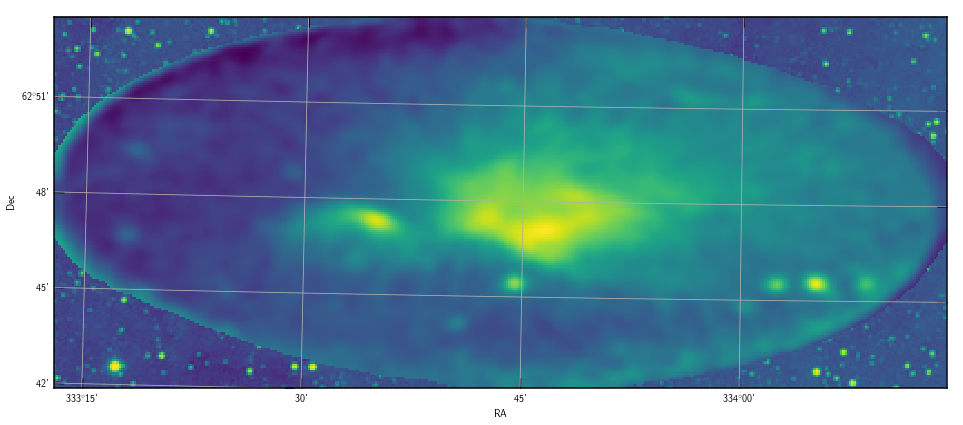

In [21]:
fig = figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=cm.viridis)
ax.imshow(signal, origin='lower')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid()

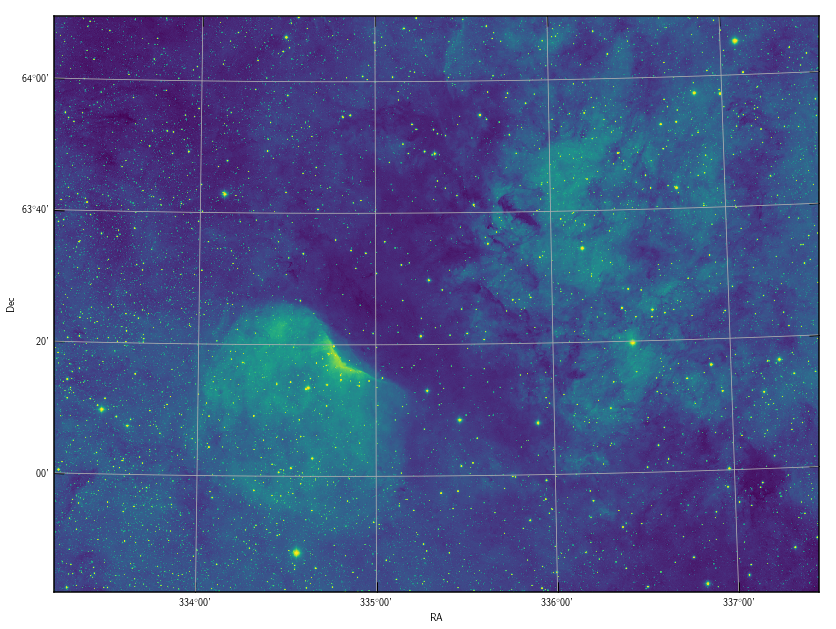

In [59]:
fig = figure(figsize=(16, 10))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=cm.viridis)
#ax.contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('RA')
ylabel('Dec')
#clim(-15, 15)
#cb = colorbar()
#cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()

In [60]:
gridx

array([[ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233],
       [ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233],
       [ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233],
       ..., 
       [ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233],
       [ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233],
       [ 332.36483249,  332.38156994,  332.39830739, ...,  339.02633743,
         339.04307488,  339.05981233]])

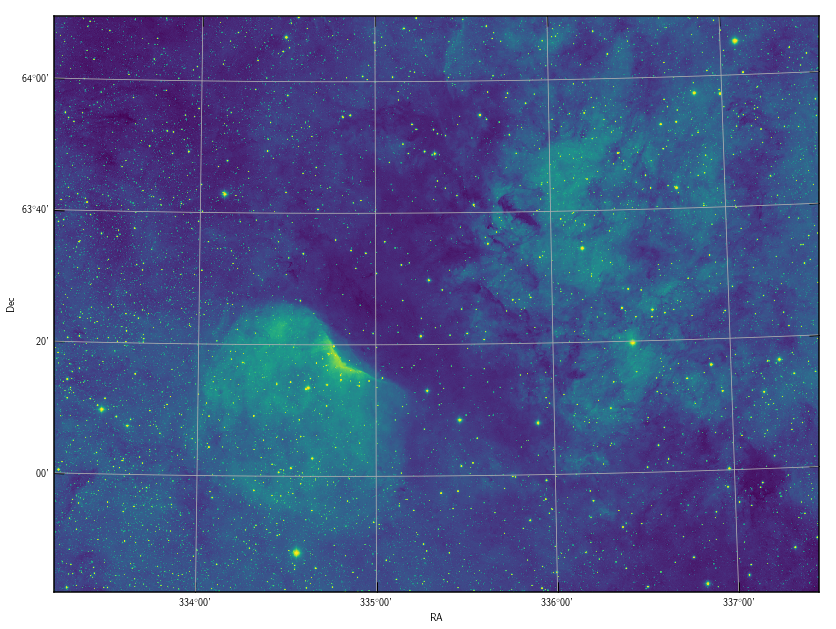

In [59]:
fig = figure(figsize=(16, 10))
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=wcs)
ax.imshow(hdu.data, origin='lower', cmap=cm.viridis)
#ax.contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
ax.plot()
xlabel('RA')
ylabel('Dec')
#clim(-15, 15)
#cb = colorbar()
#cb.set_label('$\mathrm{Flux}\ (mJy / pixel)$')
grid()

In [27]:
rgrid, dgrid = np.meshgrid(ras, decs)

In [28]:
rrs = rgrid.flatten()
dds = dgrid.flatten()

In [29]:
xs = hdu.data.flatten()

In [30]:
c = coordinates.SkyCoord(frame='icrs', ra=rrs*u.degree, dec=dds*u.degree)

In [31]:
lats = c.galactic.b.deg
lons = c.galactic.l.deg

In [32]:
nrapix = int((lons.max() - lons.min()) / (4.2 / 3600.))
ndecpix = int((lats.max() - lats.min()) / (4.2 / 3600.))

datamap, hits, lonbins, latbins = naive_map(xs, lons, lats, nrapix, ndecpix) 
mask = hits == 0
xsig = np.zeros_like(datamap)
xsig[~mask] = datamap[~mask] / hits[~mask]
xsig[mask] = np.nan

In [33]:
xsig[~mask].max()

255.0

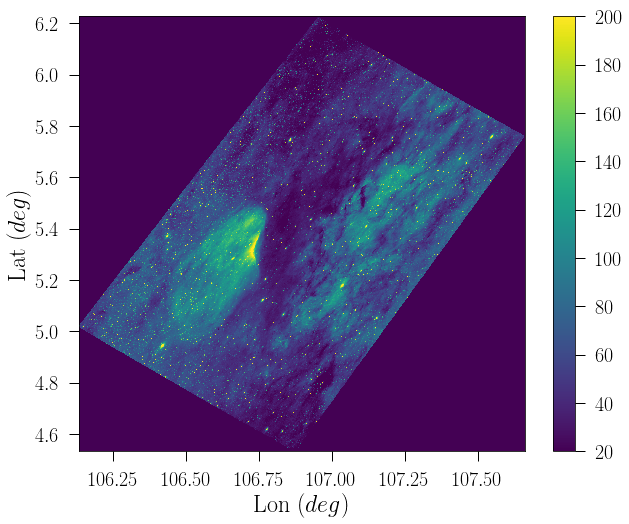

In [34]:
pcolormesh(lonbins, latbins, xsig)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
clim(20, 200)
colorbar()

In [35]:
maskx = (gridx[0, :] > lonbins[0]) * (gridx[0, :] < lonbins[-1])

In [36]:
masky = (gridy[:, 0] > latbins[0]) * (gridy[:, 0] < latbins[-1])

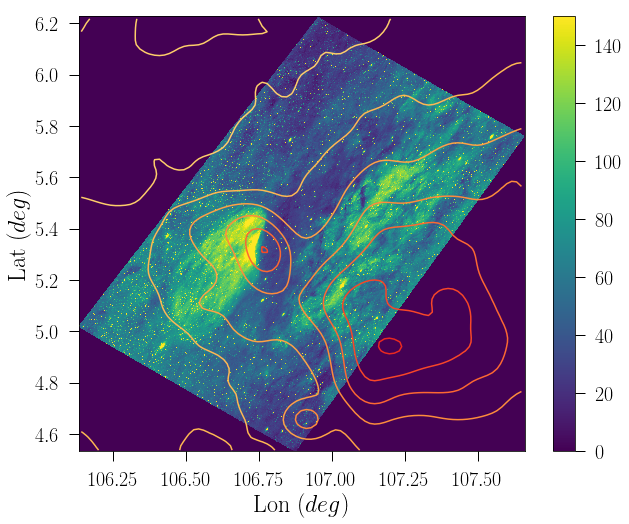

In [37]:
pcolormesh(lonbins, latbins, xsig)
clim(0, 150)
colorbar();
contour(gridx[masky, :][:, maskx], gridy[masky, :][:, maskx], signal[masky, :][:, maskx]*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#savefig('highres_halpha_contour_gal')

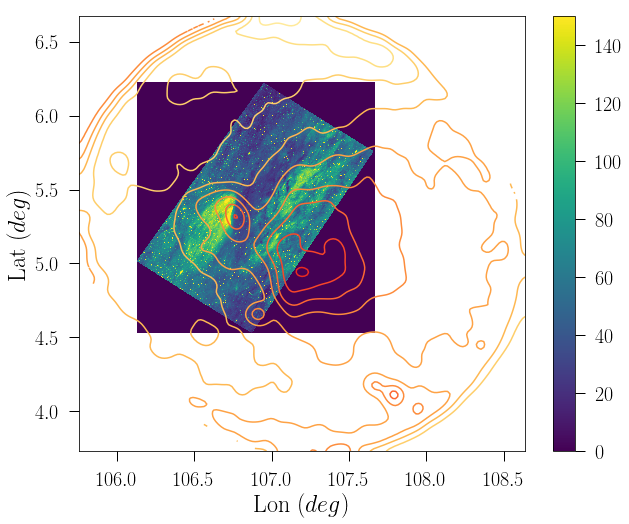

In [38]:
pcolormesh(lonbins, latbins, xsig)
clim(0, 150)
colorbar();
contour(gridx, gridy, signal*1000, levels=np.linspace(-10, 20, 15), cmap=matplotlib.cm.YlOrRd)
xlabel('$\mathrm{Lon}\ (deg)$')
ylabel('$\mathrm{Lat}\ (deg)$')
#savefig('highres_halpha_contour')

In [87]:
xmap = fits.open('../externaldata/PTF-Image.fits')

In [91]:
hdu = xmap[0]

In [92]:
hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                 2048 / STANDARD FITS FORMAT                           
NAXIS2  =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '           / Name of telescope                              
INSTRUME= 'PTF/MOSAIC'         / Instrument name                                
OBSERVER= 'KulkarniPTF'        / Observer name and project                      
CCDID   = '10      '           / CCD number (0..11)                             
DATE-OBS= '2013-06-19T11:28:32.854' / UTC shutter time YYYY-MM-DDTHH:MM:SS.SSS  
DATE    = '2013-06-19T04:50:

In [95]:
ptfmap = hdu.data

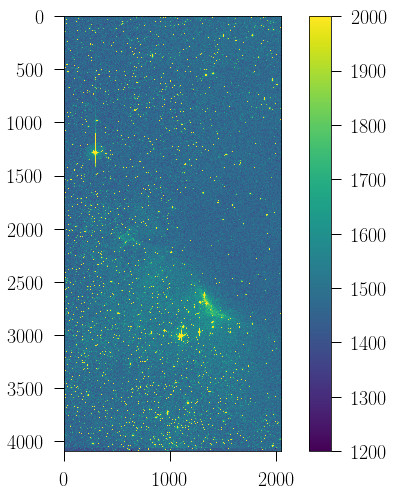

In [106]:
imshow(ptfmap)
colorbar()
clim(1200, 2000)

In [75]:
xmap = fits.open('../externaldata/r373070-3.fits.fz')

In [79]:
hdu = xmap[1]

In [80]:
hdu.header

XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   16 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 2048 / length of original image axis                  
NAXIS2  =                 4096 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
RUN     =               373070 / Run number                                     
OBSERVAT= 'LAPALMA '           / Name of observatory (IRAF style)               
OBSERVER= 'Drew    '           / Name of principal investigator                 
OBJECT  = 'intphas_7008o Ha'   / Title of observation                           
LATITUDE=            28.761978 / Telescope latitude  (degrees), +28:45:43.1     
LONGITUD=           -17.8776

In [81]:
iphas = hdu.data

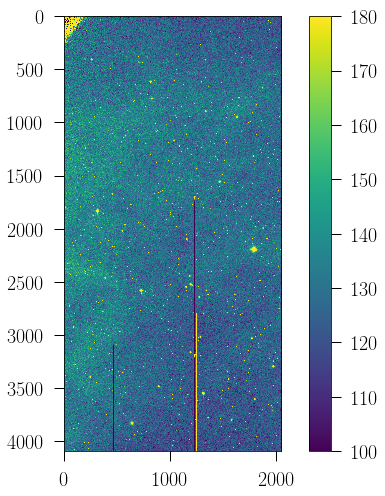

In [108]:
imshow(iphas)
colorbar()
clim(100, 180)

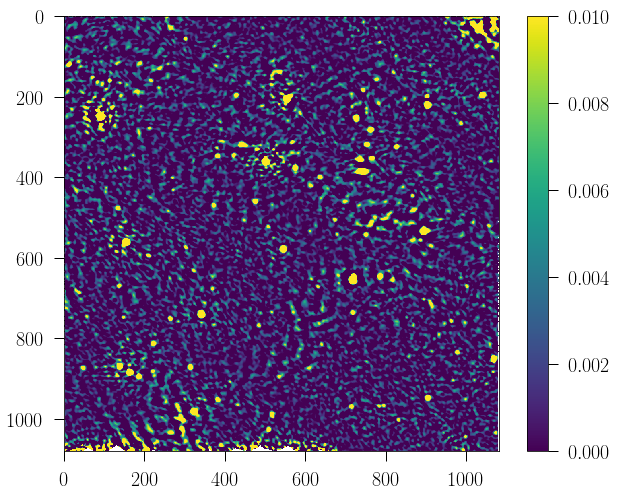

In [51]:
imshow(amimap)
colorbar()
clim(0, 0.01)

In [ ]:
xmap = fits.open('../externaldata/new-image.fits')
hdu = xmap[0]
cra = hdu.header['CRVAL1']
mra = hdu.header['CRPIX1']
cdec = hdu.header['CRVAL2']
mdec = hdu.header['CRPIX2']
spix = hdu.header['CD1_1']
ras = (np.arange(1663) - mra) * spix + cra
decs = (np.arange(1252) - mdec) * spix + cdec